In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import pathlib
import time
import os

In [34]:
def calcQ(q,ntot1,ntot2):
    #print("Ntot",ntot1,ntot2)
    ### q [0:ntot1+1,0:ntot2+1]
    mat_b = q
    fac = np.zeros(ntot1+2)
    facinv = np.zeros(ntot1+2)
    deriv_b = np.zeros((ntot1+2,ntot2+2))
    deriv_d = np.zeros((ntot1+2,ntot2+2))
    deriv_x = np.zeros((ntot1+2,ntot2+2))
    mat_a = np.zeros((ntot1+2,ntot2+2))
    mat_x = np.zeros((ntot1+2,ntot2+2))
    mat_y = np.zeros((ntot1+2,ntot2+2))
    mat_m = np.zeros((ntot1+2,ntot2+2))
    
    
    fac[0] = 1.0
    fac[1] = 1.0
    facinv[0] = 1.0
    facinv[1] = 1.0
    
    for i in range(2,ntot1+1):
        fac[i] = fac[i-1]*i
        facinv[i] = 1.0/fac[i]
    
    for i in range(0,ntot1+1):
        for j in range(0,ntot2+1):
            #print(i,j)
            deriv_b[i,j]= mat_b[i+1,j]*(i+1)
    for i in range(0,ntot1+1):
        for j in range(0,ntot2+1):
            deriv_d[i,j]= mat_b[i,j+1]*(j+1)
            
    mat_a[0,0] = mat_b[0,0]        
    for j in range(0,ntot2+1):
        deriv_x[0,j] = mat_b[0,j+1]*(j+1)
        
    mat_a[0,1] = deriv_x[0,0]
    mat_x = deriv_x
    for j in range(2,ntot2+1):
        mat_y = calc2(ntot1,ntot2,deriv_d,mat_x)
        mat_a[0,j] = mat_y[0,0] * facinv[j]
        mat_x = np.zeros((ntot1+2,ntot2+2))
        mat_x = mat_y
    
    mat_m = np.zeros((ntot1+2,ntot2+2))
    for j in range(0,ntot2+1):
        for i in range(0,ntot1+1):
            mat_m[i,j] = mat_b[i+1,j]*(i+1)
    
    mat_a[1,0] = mat_m[0,0]
    mat_x = np.zeros((ntot1+2,ntot2+2))
    mat_x = mat_m
    for j in range(0,ntot2+1):
        mat_y = calc2(ntot1,ntot2,deriv_d,mat_x)
        mat_a[1,j]=mat_y[0,0]*facinv[j]
        mat_x = np.zeros((ntot1+2,ntot2+2))
        mat_x=mat_y

    
    for i in range(2,ntot1+1):
        mat_x = np.zeros((ntot1+2,ntot2+2))
        #print("mat_m",mat_m)
        
        mat_x = calc1(ntot1,ntot2,deriv_b,mat_m)
        mat_a[i,0]=mat_x[0,0]*facinv[i]  # Corrected error here 2017.02.10
        mat_c = mat_x
        for j in range(1,ntot2+1):
            mat_y = np.zeros((ntot1+2,ntot2+2))
            mat_y = calc2(ntot1,ntot2,deriv_d,mat_x)
            mat_a[i,j]=mat_y[0,0]*facinv[i]*facinv[j]
            mat_x = np.zeros((ntot1+2,ntot2+2))
            mat_x=mat_y
        
        mat_m=mat_c
        mat_c = np.zeros((ntot1+2,ntot2+2))

    Qn = mat_y[0,0]*facinv[ntot1]*facinv[ntot2]

    
    C = np.zeros((ntot1+2,ntot2+2))
    nk = np.zeros((ntot1+2,ntot2+2))
    #Calculate <n_i,j>
    for i in range(0,ntot1+1):
        for j in range(0,ntot2+1):
            k1=ntot1-i
            k2=ntot2-j
            C[k1,k2]=mat_b[k1,k2]*mat_a[i,j]
            nk[k1,k2]=C[k1,k2]/Qn
    return (Qn,nk)


def calc1(ntot1,ntot2,deriv_b,mat_m):

    mat_x = np.zeros((ntot1+2,ntot2+2))
    mat_u = mat_m
    deriv_u = np.zeros((ntot1+2,ntot2+2))
    mat_v = np.zeros((ntot1*2+2,ntot2*2+2))
    mat_w = np.zeros((ntot1+2,ntot2+2))
    i = 0
    for m in range(0,ntot2+1):
        for j in range(0,ntot1+1):
            i += 1
            deriv_u[j,m]=mat_u[j+1,m]*(j+1)


    for j in range(0,ntot1+1):
        for p in range(0,ntot1+1):
            for l in range(0,ntot2+1):
                for k in range(0,ntot2+1):
                    r = j+p
                    s = l+k
                    if r < (ntot1+2) and s < (ntot2+2) :
                        mat_v[r,s]=mat_v[r,s]+mat_u[j,l]*deriv_b[p,k]

    
    for l in range(0,ntot1+1):
        for m in range(0,ntot2+1):
            mat_w[l,m]=deriv_u[l,m]+mat_v[l,m]      
    return mat_w

def calc2(ntot1,ntot2,deriv_d,mat_n):
    deriv_o = np.zeros((ntot1+2,ntot2+2))
    mat_p = np.zeros((ntot1*2+2,ntot2*2+2))
    mat_q = np.zeros((ntot1+2,ntot2+2))
    for j in range(0,ntot2+1):
        deriv_o[0,j]=mat_n[0,j+1]*(j+1)
    for l in range(0,ntot2+1):
        for k in range(0,ntot2+1):
            s=l+k
            mat_p[0,s]=mat_p[0,s]+mat_n[0,l]*deriv_d[0,k]
    for l in range(0,ntot2+1):
        mat_q[0,l]=deriv_o[0,l]+mat_p[0,l]
        
    return mat_q
            
            


In [38]:
### functions

def K2q_lnq(N,K,V):
    q = np.zeros((N,N))
    lnq = np.zeros((N,N))

    for i in range(K.shape[0]):
        q[int(K[i,0]), int(K[i,1])]= K[i,2]*(V**(1-K[i,0]-K[i,1]))
        lnq[int(K[i,0]), int(K[i,1])] = np.log(q[int(K[i,0]), int(K[i,1])])
    q[0,0] = 1
    q[0,1] = 1
    q[1,0] = 1
    lnq[0,0] = 0
    lnq[0,1] = 0
    lnq[1,0] = 0
    
    return q, lnq
    
    
def nsim2mat(N,nsim_input):
    nsim = np.zeros((N,N))
    for i in range(nsim_input.shape[0]):
        nsim[int(nsim_input[i,0]),int(nsim_input[i,1])]= nsim_input[i,2]
    return nsim
        
    
    
def calcf(Q,lnq,nsim,f_sum):
    f = -np.log(Q)+ sum(sum(nsim*lnq))
    f_sum = f_sum + f
    return f_sum
    
def calcgrad(nsim,nk,grad_sum,N):
    grad = nsim-nk
    
    grad_sum_ = 0
    if type(grad_sum) != int:
        grad_sum_ = np.zeros((N,N))
        for i in range(grad_sum.shape[0]):
            for j in range(grad_sum.shape[1]):
                grad_sum_[i,j] = grad_sum[i,j]
    grad_sum = grad_sum_ + grad
    
    return grad_sum


def q2K(nrow,q,V):
    K = np.zeros((nrow+1,3))
    
    i = 0
    for j in range(q.shape[0]):
        for k in range(q.shape[1]):
            if q[j,k] != 0:
                K[i,0] = j
                K[i,1] = k
                K[i,2] = q[j,k]*(V**(j+k-1))
                i += 1
    return K



def nk2conc(nrow, nk, V):
    
    conc = np.zeros((nrow+1,3))
    
    i=0
    for j in range(nk.shape[0]):
        for k in range(nk.shape[1]):
             if nk[j,k] != 0:
                conc[i,0] = j
                conc[i,1] = k
                conc[i,2] = nk[j,k]
                i += 1
            
    return conc

In [39]:
# #### Input Temperature, N and V
# input_N = 40
# V = [ 96.384,114.817]
# T = 295
# ############################################
# N = input_N +2
# trajN = [0,1]
# input_Kfile = "BPMS-LastKactual.xvg"

def Opt_(input_N,V,T,trajN,input_Kfile,iter_num,outputFile,inputstart_num=1,alpha_=0.1):
    if os.path.exists(outputFile) == False:
        pathlib.Path(outputFile).mkdir(parents=True, exist_ok=True)
    ############################################
    N = input_N +2
    ### read in K
    #Ktable = pd.read_csv("NaOA_{0}/K_{0}.xvg".format(T),sep='\s+',header=None).values
    Ktable = pd.read_csv("NaOA_{0}/{1}".format(T,input_Kfile),sep='\s+',header=None).values
    nrow = Ktable.shape[0]
    #Ktable.columns=["j","k","K"]

    q = {}
    lnq = {}
    for m in trajN:
        q[m],lnq[m] = K2q_lnq(N,Ktable,V[m])
        #q[1],lnq[1] = K2q_lnq(N,Ktable,V[1])
    #######################################################################################
    ###
    # Koutput = q2K(nrow,q[0],V[0])
    # np.savetxt("NaOA_{0}/Output_K_initial.txt".format(T),Koutput)
    ###


    f_sum = 0
    grad_sum = 0
    nsim_input = {}
    nsim = {}
    nk = {}
    Ck = {}
    nkrow = {}
    #######################################################################################
    for N_traj in trajN:

        nsim_input[N_traj] = pd.read_csv("NaOA_{0}/nsim_V{1}.txt".format(T,N_traj),sep='\s+',header=None).values
        nsim[N_traj] = nsim2mat(N,nsim_input[N_traj])
        nkrow[N_traj]  = nsim_input[N_traj].shape[0]
        ### Generate objective function values
        
        Q,nk[N_traj] = calcQ(q[N_traj],N-2,N-2)
        #Q,nk[N_traj] = calcQ(q[N_traj],N-2,N-2)
        
        #np.savetxt("NaOA_295/nk_test_{0}.txt".format(N_traj),nk[N_traj])
        f_sum = calcf(Q,lnq[N_traj],nsim[N_traj],f_sum)

        ### Generate grad values
        grad_sum = calcgrad(nsim[N_traj],nk[N_traj],grad_sum,N)

        print(N_traj,"Q",Q,"f",f_sum)
    #######################################################################################

    if inputstart_num == 1:
        for N_traj in trajN:
            #Coutput= nk2conc(nkrow[N_traj], nk[N_traj], V[N_traj])
            Coutput= nk2conc(nrow, nk[N_traj], V[N_traj])
            #np.savetxt("NaOA_{0}/Output_C{1}_iter0.txt".format(T,N_traj),Coutput)
            np.savetxt("{0}/Output_C{1}_iter0.txt".format(outputFile,N_traj),Coutput)
            ###
            Koutput = q2K(nrow,q[N_traj],V[N_traj])
            #np.savetxt("NaOA_{0}/Output_K{1}_iter0.txt".format(T,N_traj),Koutput)
            np.savetxt("{0}/Output_K{1}_iter0.txt".format(outputFile,N_traj),Koutput)
        

    f_ = [f_sum]
    ##################################
    k = inputstart_num
    x0 = lnq
    x = {}
    alpha = alpha_
    while k < (inputstart_num + iter_num):
        
        for m in trajN:
            x[m] = (x0[m] + alpha*grad_sum) * (x0[m] != 0)
            q[m] = np.exp(x[m]) * (x[m] != 0)
            q[m][0,0] = 1
            q[m][1,0] = 1
            q[m][0,1] = 1
        
        #         x[0] = (x0[0] + alpha*grad_sum) * (x0[0] != 0)
        #         x[1] = (x0[1] + alpha*grad_sum) * (x0[1] != 0)
        #         #print("x",x)

        #         ### revert x to qmatrix 
        #         q[0] = np.exp(x[0]) * (x[0] != 0)
        #         q[0][0,0] = 1
        #         q[0][1,0] = 1
        #         q[0][0,1] = 1

        #         q[1] = np.exp(x[1]) * (x[1] != 0)
        #         q[1][0,0] = 1
        #         q[1][1,0] = 1
        #         q[1][0,1] = 1

        f_sum = 0 
        grad_sum = 0
        grad_sum_ = 0
        for N_traj in trajN:

            ### Generate objective function values
            Q,nk[N_traj] = calcQ(q[N_traj],N-2,N-2)
        
            f_sum = calcf(Q,x[N_traj],nsim[N_traj],f_sum)

            ### Generate grad values
            grad_sum = calcgrad(nsim[N_traj],nk[N_traj],grad_sum,N)


        f_.append(f_sum)
        ### Output
        print("k",k,"f_sum",f_sum)
        for N_traj in trajN:
            Coutput= nk2conc(nrow, nk[N_traj], V[N_traj])
            #np.savetxt("NaOA_{0}/Output_C{1}_iter{2}.txt".format(T,N_traj,k),Coutput)
            np.savetxt("{0}/Output_C{1}_iter{2}.txt".format(outputFile,N_traj,k),Coutput)
            Koutput = q2K(nrow,q[N_traj],V[N_traj])
            #np.savetxt("NaOA_{0}/Output_K{1}_iter{2}.txt".format(T,N_traj,k),Koutput)
            np.savetxt("{0}/Output_K{1}_iter{2}.txt".format(outputFile,N_traj,k),Koutput)
        #### update
        x0 = x
        k += 1

    plt.plot(f_)

### 300K Guess 1

In [9]:
os.getcwd()

'/Users/xiaokunzhang/Documents/Research/NaDA/Traj_bayes/Mtraj_OA_300'

0 Q 6.5047161834523565e-74 f 29.063029373313043
1 Q 2.6651910959446834e-77 f 74.40899996750338
2 Q 8.025168211097684e-80 f 142.43980267325412
k 1 f_sum 142.44006321905468
k 2 f_sum 142.44024256463948
k 3 f_sum 142.44037708065352
k 4 f_sum 142.44049522990176
k 5 f_sum 142.4405972938716
k 6 f_sum 142.4406934334206
k 7 f_sum 142.44078059885268
k 8 f_sum 142.4408642670524
k 9 f_sum 142.44094192947912
k 10 f_sum 142.44101702261793
k 11 f_sum 142.4410878140128
time 1714.9503638744354


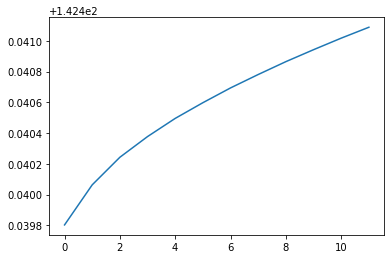

In [15]:
time1 = time.time()
Opt_(40,[96.384,114.817,135.54],300,[0,1,2],"BPMS-LastKactual.xvg",10,"NaOA_300/PEACH_guess1")
time2 = time.time()
print('time',time2-time1)

## 305 K Guess 1

0 Q 5.529861646622474e-78 f 37.510792402767066
1 Q 9.329653842387591e-81 f 97.52436045776355
k 1 f_sum 97.52492201178816
k 2 f_sum 97.52509216708005
k 3 f_sum 97.525187961932
k 4 f_sum 97.52525604704815
k 5 f_sum 97.52530936799259
k 6 f_sum 97.5253538860512
k 7 f_sum 97.52539293663888
k 8 f_sum 97.52542848917008
k 9 f_sum 97.5254617340589
k 10 f_sum 97.52549340516013
k 11 f_sum 97.52552396455413
time 1112.9534590244293


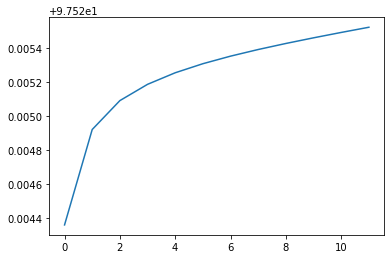

In [18]:
time1 = time.time()
# Opt_(input_N,V,T,trajN,input_Kfile,iter_num,outputFile,inputstart_num=1)
Opt_(input_N = 40,V= [114.817,135.54],T= 305,trajN= [0,1],input_Kfile= "BPMS-LastKactual.xvg",
     iter_num =10,outputFile= "NaOA_305/PEACH_guess1",alpha_=0.1)
time2 = time.time()
print('time',time2-time1)

## 305K guess 3

0 Q 7.311953935725116e-75 f 37.44216646469587
1 Q 4.1595091679085365e-78 f 96.07641342856807
k 1 f_sum 96.45567136300464
k 2 f_sum 96.55230325063874
k 3 f_sum 96.62558755909228
k 4 f_sum 96.68131875432502
k 5 f_sum 96.72410471714987
k 6 f_sum 96.75749148216549
k 7 f_sum 96.78410208347066
k 8 f_sum 96.80582064065986
k 9 f_sum 96.823974638235
k 10 f_sum 96.83949030399012
time 995.101343870163


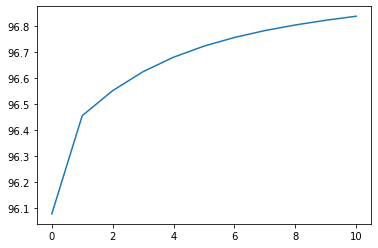

In [20]:
time1 = time.time()
# Opt_(input_N,V,T,trajN,input_Kfile,iter_num,outputFile,inputstart_num=1)
Opt_(input_N = 40,V= [114.817,135.54],T= 305,trajN= [0,1],input_Kfile= "K_lawofmass.xvg",
     iter_num =10,outputFile= "NaOA_305/Lawofmass_guess3",alpha_=0.1)
time2 = time.time()
print('time',time2-time1)